In [12]:
%load_ext autoreload
%autoreload 2

In [53]:
import tensorflow as tf
import keras
from models import model_v1
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network

In [28]:
# dataset
from pathlib import Path
from data_generator import DataGenerator

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train"
train_gen = DataGenerator(train_path,mode="unsupervised")

# tensorflow dataset
im_shape = (train_gen.crop_size,train_gen.crop_size,3)
output_signature = ((tf.TensorSpec(shape=im_shape,dtype=tf.float32),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)

def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(8)
    return ds

train_ds = config_ds(train_ds)

(8, 128, 128, 3) (8, 128, 128, 3)
(8, 128, 128, 3)


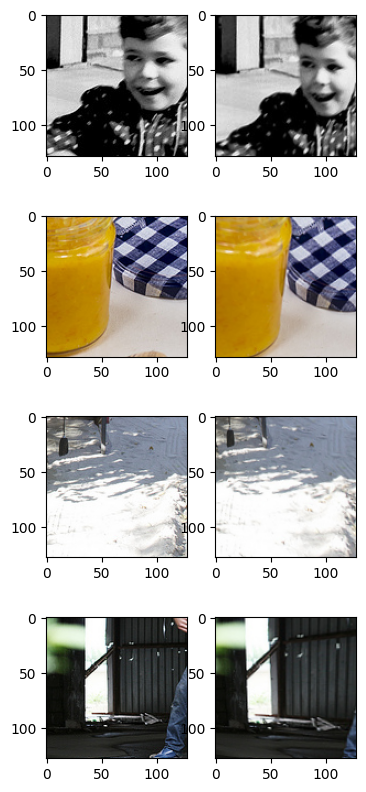

In [64]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))
print(sample_input[0].shape, sample_input[1].shape)
print(sample_output.shape)

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [57]:
# build new model with TensorDLT and STN added
homography_net = model_v1()

# retrieve the input of the network
img_input = homography_net.input

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=homography_net.output)

# use spatial transformer to get predicted image 
img_pred = spatial_transformer_network(img_input[0],
                                       homography,
                                       img_height=img_input[0].shape[1],
                                       img_width=img_input[0].shape[2],
                                       )

full_model = keras.Model(inputs=img_input, outputs=img_pred)
full_model.summary()


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_36 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 128, 128, 3)          0         ['input_35[0][0]']            
 10 (SlicingOpLambda)                                                                             
                                                                                                  
 tf.__operators__.getitem_2  (None, 128, 128, 3)          0         ['input_36[0][0]']     

In [59]:
# try calling the full model with sample input
sample_model_output = full_model(sample_input)
print(sample_model_output.shape)
assert(sample_model_output.shape==sample_input[0].shape)

(8, 128, 128, 3)


In [69]:
# define loss function
def custom_loss_unsupervised(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred))

# compile model
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss=custom_loss_unsupervised)

In [70]:
# start training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

history = full_model.fit(train_ds,epochs=20,verbose=True,steps_per_epoch=150,
                    callbacks=[reduce_lr])

Epoch 1/20
150/150 [==============================] - 64s 411ms/step - loss: 29.6703 - lr: 0.0100
Epoch 2/20
150/150 [==============================] - 62s 413ms/step - loss: 28.5974 - lr: 0.0100
Epoch 3/20
150/150 [==============================] - 63s 421ms/step - loss: 26.7569 - lr: 0.0100
Epoch 4/20
150/150 [==============================] - 63s 420ms/step - loss: 26.1968 - lr: 0.0100
Epoch 5/20
150/150 [==============================] - 62s 414ms/step - loss: 25.6343 - lr: 0.0100
Epoch 6/20
150/150 [==============================] - 63s 417ms/step - loss: 26.1232 - lr: 0.0100
Epoch 7/20
150/150 [==============================] - 63s 417ms/step - loss: 25.9992 - lr: 0.0100
Epoch 8/20
150/150 [==============================] - 63s 420ms/step - loss: 25.4016 - lr: 0.0100
Epoch 9/20
150/150 [==============================] - 63s 420ms/step - loss: 25.6958 - lr: 0.0100
Epoch 10/20
150/150 [==============================] - 61s 405ms/step - loss: 26.3905 - lr: 0.0100
Epoch 11/20
150/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


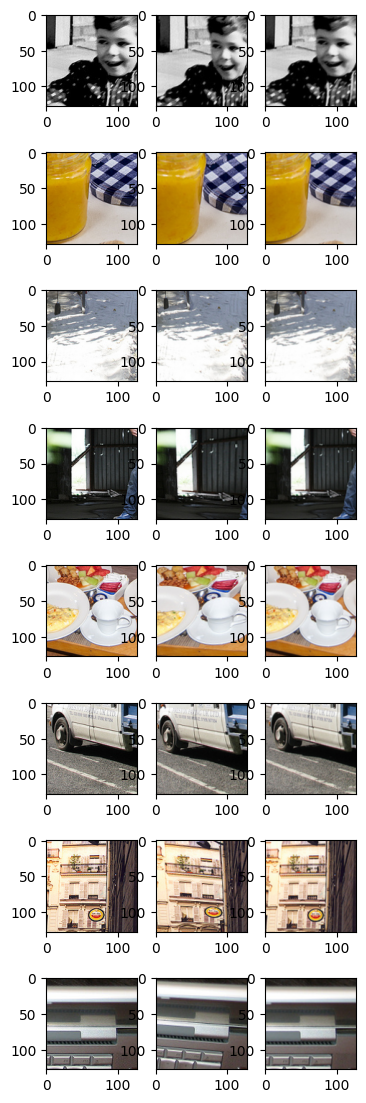

In [71]:
# see how the model is doing
sample_model_output = full_model(sample_input)
plt.figure(figsize=(4,14))
for i in range(8):
    plt.subplot(8,3,3*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+3)
    plt.imshow(tf.squeeze(sample_model_output[i,:,:,:])/255.)
plt.show()